# Compressing SetFit Models with Knowledge Distillation

## 1. Setup development environment

Our first step is to install SetFit. Running the following cell will install all the required packages for us, including Intel Neural Compressor and 🤗 Optimum:

In [ ]:
%pip install setfit neural_compressor optimum[onnxruntime] onnxruntime_extensions

While we're at it, let's turn off some of the warnings from the 🤗 Datasets library and the tokenizers:

In [1]:
import datasets

datasets.logging.set_verbosity_error()

%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


To be able to share your model with the community, there are a few more steps to follow.

First, you have to store your authentication token from the Hugging Face Hub (sign up here if you haven't already!). To do so, execute the following cell and input an access token associated with your account:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Create a performance benchmark

In [2]:
from pathlib import Path
from time import perf_counter

import evaluate
import numpy as np
import torch
from tqdm.auto import tqdm

metric = evaluate.load("accuracy")


class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_model(self, query="What is the pin number for my account?"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.model([query])
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

## Train teacher and student baselines

In [3]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from setfit import sample_dataset

In [5]:
train_dataset = dataset["train"].train_test_split(seed=42)

In [6]:
train_dataset_teacher = sample_dataset(train_dataset["train"])
train_dataset_student = train_dataset["test"].select(range(1000))
test_dataset = dataset["test"]

  0%|          | 0/90 [00:00<?, ?ba/s]

  0%|          | 0/90 [00:00<?, ?ba/s]

  0%|          | 0/90 [00:00<?, ?ba/s]

  0%|          | 0/90 [00:00<?, ?ba/s]

In [7]:
from setfit import SetFitModel, SetFitTrainer

teacher_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2"
)
teacher_trainer = SetFitTrainer(
    model=teacher_model, train_dataset=train_dataset_teacher
)
teacher_trainer.train()
pb = PerformanceBenchmark(
    model=teacher_trainer.model, dataset=test_dataset, optim_type="MPNet (teacher)"
)
perf_metrics = pb.run_benchmark()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/80 [00:00<?, ?it/s]

Model size (MB) - 417.74
Accuracy on test set - 0.823
Average latency (ms) - 13.46 +\- 0.57


In [8]:
baseline_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-MiniLM-L3-v2"
)
baseline_trainer = SetFitTrainer(
    model=baseline_model, train_dataset=train_dataset_teacher
)
baseline_trainer.train()
pb = PerformanceBenchmark(baseline_trainer.model, test_dataset, "MiniLM-L3 (student)")
perf_metrics.update(pb.run_benchmark())

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/80 [00:00<?, ?it/s]

Model size (MB) - 66.36
Accuracy on test set - 0.745
Average latency (ms) - 4.20 +\- 0.17


## Compare performance

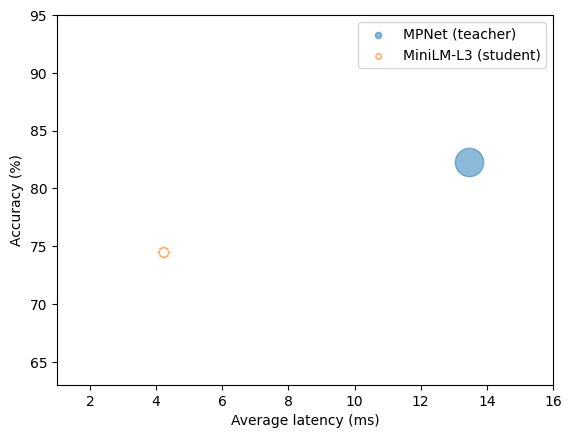

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx,
                marker="$\u25CC$",
            )
        else:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                s=df_opt["size_mb"],
                label=idx,
                alpha=0.5,
            )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["MPNet (teacher)"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


plot_metrics(perf_metrics, "MiniLM-L3 (student)")

## Train with knowledge distillation

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 40000
  Num epochs = 1
  Total optimization steps = 2500
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2500 [00:00<?, ?it/s]

Model size (MB) - 66.36
Accuracy on test set - 0.829
Average latency (ms) - 4.16 +\- 0.18


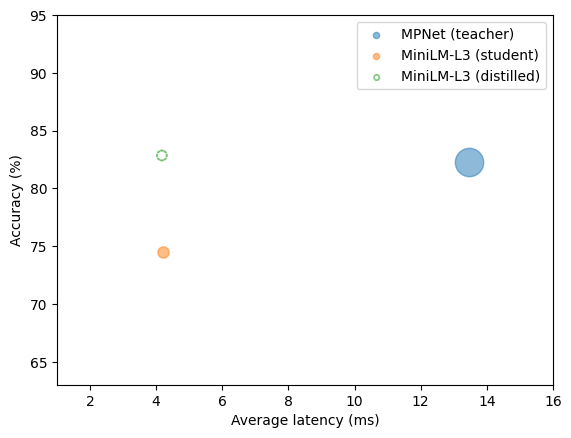

In [10]:
from setfit import DistillationSetFitTrainer

student_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-MiniLM-L3-v2"
)
student_trainer = DistillationSetFitTrainer(
    teacher_model=teacher_model,
    train_dataset=train_dataset_student,
    student_model=student_model,
)
student_trainer.train()

pb = PerformanceBenchmark(
    student_trainer.student_model, test_dataset, "MiniLM-L3 (distilled)"
)
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, "MiniLM-L3 (distilled)")

## Push to Hub

In [ ]:
student_trainer.push_to_hub("setfit-minilm-distilled")

## Export to ONNX

In [11]:
!rm -rf onnx

In [13]:
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer

model_id = "setfit-minilm-distilled"
onnx_path = Path("onnx")
ort_model = ORTModelForFeatureExtraction.from_pretrained(
    model_id, from_transformers=True
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
ort_model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)

('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

In [14]:
from setfit.exporters.utils import mean_pooling
from sklearn.linear_model import LogisticRegression


class OnnxSetFitModel:
    def __init__(self, ort_model, tokenizer):
        self.ort_model = ort_model
        self.tokenizer = tokenizer
        self.model_head = LogisticRegression()

    def fit(self, x_train, y_train):
        inputs = self.tokenizer(
            x_train, padding=True, truncation=True, return_tensors="pt"
        )
        outputs = self.ort_model(**inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], inputs["attention_mask"]
        )
        self.model_head.fit(embeddings, y_train)

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        )
        outputs = self.ort_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings)

    def __call__(self, inputs):
        return self.predict(inputs)

## Cost analysis

## Apply dynamic quantization with Intel Neural Compressor

In [15]:
import functools

import evaluate
import onnxruntime
from optimum.pipelines import ORTModelForFeatureExtraction
from sklearn.linear_model import LogisticRegression

accuracy = evaluate.load("accuracy")


def eval_func(model):
    ort_model = ORTModelForFeatureExtraction.from_pretrained(onnx_path)
    ort_model.model = onnxruntime.InferenceSession(model.SerializeToString(), None)
    onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer)
    onnx_setfit_model.fit(train_dataset_teacher["text"], train_dataset_teacher["label"])
    preds = []
    chunk_size = 100
    for i in tqdm(range(0, len(test_dataset["text"]), chunk_size)):
        preds.extend(
            onnx_setfit_model.predict(test_dataset["text"][i : i + chunk_size])
        )
    labels = test_dataset["label"]
    accuracy = metric.compute(predictions=preds, references=labels)
    return accuracy["accuracy"]

In [17]:
def build_dynamic_quant_yaml():
    yaml = """
model:
  name: bert
  framework: onnxrt_integerops
  
device: cpu

quantization:
  approach: post_training_dynamic_quant

tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 9527
    """
    with open("MiniLM_L3_distilled_onnx_dynamic.yaml", "w", encoding="utf-8") as f:
        f.write(yaml)


build_dynamic_quant_yaml()

In [18]:
from neural_compressor.experimental import Quantization, common

onnx_output_path = "onnx/model_quantized.onnx"
quantizer = Quantization("MiniLM_L3_distilled_onnx_dynamic.yaml")

In [22]:
quantizer.model = common.Model("onnx/model.onnx")
quantizer.eval_func = functools.partial(eval_func)
quantized_model = quantizer()

2022-12-13 21:24:59 [INFO] Get FP32 model baseline.


  0%|          | 0/76 [00:00<?, ?it/s]

2022-12-13 21:25:53 [INFO] Save tuning history to /home/lewis_huggingface_co/git/workshops/fewshot-learning-in-production/nc_workspace/2022-12-13_21-22-43/./history.snapshot.
2022-12-13 21:25:53 [INFO] FP32 baseline is: [Accuracy: 0.8155, Duration (seconds): 54.3426]
2022-12-13 21:25:57 [INFO] |**********Mixed Precision Statistics*********|
2022-12-13 21:25:57 [INFO] +-----------------------+-------+------+------+
2022-12-13 21:25:57 [INFO] |        Op Type        | Total | INT8 | FP32 |
2022-12-13 21:25:57 [INFO] +-----------------------+-------+------+------+
2022-12-13 21:25:57 [INFO] |         Gather        |   5   |  3   |  2   |
2022-12-13 21:25:57 [INFO] |         MatMul        |   21  |  21  |  0   |
2022-12-13 21:25:57 [INFO] |    DequantizeLinear   |   3   |  3   |  0   |
2022-12-13 21:25:57 [INFO] | DynamicQuantizeLinear |   18  |  18  |  0   |
2022-12-13 21:25:57 [INFO] +-----------------------+-------+------+------+
2022-12-13 21:25:57 [INFO] Pass quantize model elapsed ti

  0%|          | 0/76 [00:00<?, ?it/s]

2022-12-13 21:26:48 [INFO] Tune 1 result is: [Accuracy (int8|fp32): 0.8155|0.8155, Duration (seconds) (int8|fp32): 51.1710|54.3426], Best tune result is: [Accuracy: 0.8155, Duration (seconds): 51.1710]
2022-12-13 21:26:48 [INFO] |**********************Tune Result Statistics**********************|
2022-12-13 21:26:48 [INFO] +--------------------+----------+---------------+------------------+
2022-12-13 21:26:48 [INFO] |     Info Type      | Baseline | Tune 1 result | Best tune result |
2022-12-13 21:26:48 [INFO] +--------------------+----------+---------------+------------------+
2022-12-13 21:26:48 [INFO] |      Accuracy      | 0.8155   |    0.8155     |     0.8155       |
2022-12-13 21:26:48 [INFO] | Duration (seconds) | 54.3426  |    51.1710    |     51.1710      |
2022-12-13 21:26:48 [INFO] +--------------------+----------+---------------+------------------+
2022-12-13 21:26:48 [INFO] Save tuning history to /home/lewis_huggingface_co/git/workshops/fewshot-learning-in-production/nc_w

In [23]:
quantized_model.save("onnx/model_quantized.onnx")

In [24]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_accuracy(self):
        preds = []
        chunk_size = 100
        for i in tqdm(range(0, len(self.dataset["text"]), chunk_size)):
            preds.extend(self.model.predict(self.dataset["text"][i : i + chunk_size]))
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

In [28]:
ort_model = ORTModelForFeatureExtraction.from_pretrained(
    onnx_path, file_name="model_quantized.onnx"
)
onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer)
onnx_setfit_model.fit(train_dataset_teacher["text"], train_dataset_teacher["label"])

Model size (MB) - 17.13


  0%|          | 0/76 [00:00<?, ?it/s]

Accuracy on test set - 0.816
Average latency (ms) - 1.53 +\- 0.08


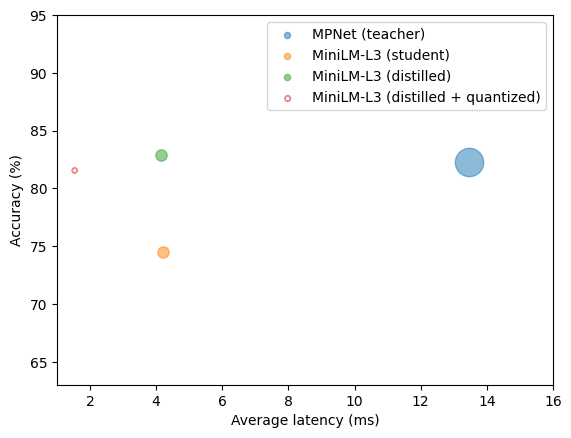

In [29]:
pb = OnnxPerformanceBenchmark(
    onnx_setfit_model,
    test_dataset,
    "MiniLM-L3 (distilled + quantized)",
    model_path="onnx/model_quantized.onnx",
)
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, "MiniLM-L3 (distilled + quantized)")

## FIN

In [49]:
teacher_model(train_dataset["train"].shuffle(seed=0)[:2]["text"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([2, 1])

In [48]:
student_model(train_dataset["train"].shuffle(seed=0)[:2]["text"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([0, 1])

### Quantize with ONNX Runtime

In [50]:
import onnxruntime
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("setfit-mnpet-distilled")
input_text = train_dataset["train"].shuffle(seed=0)[:2]["text"]

inputs = tokenizer(
    input_text,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors="np",
)

session = onnxruntime.InferenceSession(output_path)

onnx_preds = session.run(None, dict(inputs))[0]
onnx_preds

array([0, 1], dtype=int64)

In [52]:
import onnx

onnx_model = onnx.load(output_path)

In [58]:
session = onnxruntime.InferenceSession(onnx_model.SerializeToString(), None)
onnx_preds = session.run(None, dict(inputs))[0]
onnx_preds

array([0, 1], dtype=int64)